# Collaborator Analysis

This notebook contains the generic code for extracting means. We shall use this code for all our analysis.

## Importing relevant libraries, and loading relevant files

In [2]:
# Importing relevant libraries

import pandas as pd
from scipy import stats
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# Fixing a random state
np.random.seed(3)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [3]:
# Reading paths
INDIR = "../../plot_data/3/"
# Path to where we will save our processed files
OUTDIR = "../../plots/"


In [4]:
# Reading relevant files
df_treatment = pd.read_csv(INDIR+
                           "RWMAG_rematched_treatment_augmented_rematching_30perc.csv")

df_control = pd.read_csv(INDIR+\
                           "RWMAG_rematched_control_augmented_rematching_30perc.csv")


In [5]:
# Only extracting first and last authors
df_treatment = df_treatment[df_treatment['MAGAIDFirstORLastAuthorFlag']=='MAGFirstOrLastAuthor']

df_control = df_control[df_control['MAGAIDFirstORLastAuthorFlag']=='MAGFirstOrLastAuthor']

In [7]:
df_treatment['MAGAID'].nunique(), df_control['MAGAID'].nunique()

(803, 803)

## Computing Confidence Intervals

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

## Computing the effect, size and significance

In [9]:
def extract_means(outcome=None, stratification_key=None, stratification_value=None, root='overall', frac=None,
                 test='ks', alpha=0.05, printflag=False):
    
    df_treatment_i = df_treatment[['MAGAID',outcome]]\
                            .drop_duplicates()

    df_control_i = df_control[['MAGAID','MatchMAGAID',outcome]]\
                        .drop_duplicates()
        
    if(stratification_key):
        # The stratification key here means if we want to stratify the data into say male vs. female 

        df_treatment_i = df_treatment[df_treatment[stratification_key].eq(stratification_value)]\
                                          [['MAGAID',outcome]]\
                                            .drop_duplicates()

        df_control_i = df_control[df_control[stratification_key].eq(stratification_value)]\
                            [['MAGAID','MatchMAGAID',outcome]]\
                            .drop_duplicates()

    if(frac):
        # This means the function may have been called for bootstrapping
        df_treatment_i = df_treatment_i.sample(frac=frac, replace=True)
        selected_magaids = df_treatment_i.MAGAID.unique()
        df_control_i = df_control_i[df_control_i.MAGAID.isin(selected_magaids)]
    
    # Getting the average match
    df_avg_control = df_control_i.groupby("MAGAID")[outcome].mean()
    
    # Merging the treatment and control to get statistical test
    df_merged = df_treatment_i.\
                    rename(columns={outcome:outcome+"Treatment"}).\
                    merge(df_avg_control.reset_index().rename(columns={outcome:outcome+"Control"}),
                          on='MAGAID')
    
    # Getting the average treatment
    mean_treatment_i = float(df_merged[outcome+'Treatment'].mean())
    
    # Getting the average control
    mean_control_i = float(df_merged[outcome+'Control'].mean())
    
    # Getting the number of samples
    n_samples = df_merged.shape[0]
    
    lst_delta = (df_merged[outcome+'Treatment'] - df_merged[outcome+'Control']).tolist()
    delta_mean, conf_lower, conf_upper = mean_confidence_interval(lst_delta, confidence=0.95)
    #print(n_samples, delta_mean, conf_lower,conf_upper)
    
    # Now doing the statistical test
    pvalue_welch, pvalue_wilcoxon, pvalue_ks = -1,-1,-1
    
    try:
        teststats_welch = stats.ttest_ind(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'], equal_var=False)
        _, pvalue_welch = teststats_welch
    except:
        "do nothing"
    
    try:
        teststats_wilcoxon = stats.wilcoxon(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'])
        _, pvalue_wilcoxon = teststats_wilcoxon
    except:
        "do nothing"
        
    try:
        teststats_ks = stats.ks_2samp(df_merged[outcome+'Treatment'], 
                                        df_merged[outcome+'Control'])
        _, pvalue_ks = teststats_ks
        
    except:
        "do nothing"
    
    
    
    if(printflag):
        
        print_string = ""

        if(mean_treatment_i > mean_control_i):
            if(pvalue <= alpha):

                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<u><span style='color:red'>**"+str(mean_treatment_i)+"**</span></u>, "+\
                    "<span style='color:green'>"+str(mean_control_i)+"</span>"

            else:
                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>**"+str(mean_treatment_i)+"**</span>, "+\
                    "<span style='color:green'>"+str(mean_control_i)+"</span>"

        else:
            if(pvalue <= alpha):
                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>"+str(mean_treatment_i)+"</span>, "+\
                    "<u><span style='color:green'>**"+str(mean_control_i)+"**</span></u>"
            else:

                print_string = "Output for **" + root + \
                    "** (<span style='color:red'>treatment (" +str(n_samples)+ ")</span>, <span style='color:green'>control</span>):  "+\
                    "<span style='color:red'>"+str(mean_treatment_i)+"</span>, "+\
                    "<span style='color:green'>**"+str(mean_control_i)+"**</span>"

        printmd(print_string)
    
    return n_samples, mean_treatment_i, mean_control_i, pvalue_welch, pvalue_wilcoxon, pvalue_ks, delta_mean, conf_lower, conf_upper

In [10]:
def analyze(outcome):

    # Creating a dictionary for the analysis
    dict_analysis = {}

    # Overall
    dict_analysis['overall'] = extract_means(outcome=outcome, stratification_key=None, stratification_value=None, root='overall')

    # Gender
    dict_analysis['male'] = extract_means(outcome=outcome,stratification_key='GenderizeGender', 
                  stratification_value='male', root='male')
    dict_analysis['female'] = extract_means(outcome=outcome,stratification_key='GenderizeGender', 
                  stratification_value='female', root='female')
    
    for decade in sorted(df_treatment['DemiDecadeOfRetraction'].unique().tolist()):
        dict_analysis[decade] = extract_means(outcome=outcome, stratification_key='DemiDecadeOfRetraction', 
                      stratification_value=decade, root=decade)

    # Disciplines
    for discipline in sorted(df_treatment.MAGFieldName.unique().tolist()):
        if(df_treatment[df_treatment.MAGFieldName.eq(discipline)].MAGAID.nunique() >= 5):
            dict_analysis[discipline] = extract_means(outcome=outcome, stratification_key='MAGFieldName', 
                          stratification_value=discipline, root=discipline)
    # Reasons
    reason_key = 'ReasonPropagatedMajorityOfMajority'
    
#     for reason in sorted(df_treatment[reason_key].unique().tolist()):
#         try:
#             extract_means(outcome=outcome, stratification_key=reason_key, 
#                           stratification_value=reason, root=reason)
#         except:
#             print("Cant process",reason)

    # Reasons
    for reason in df_treatment[reason_key].unique().tolist():
        try:
            dict_analysis[reason] = extract_means(outcome=outcome, stratification_key=reason_key, 
                          stratification_value=reason, root=reason)
        except:
            print("Cant process",reason)
            
    # Affiliation Rank
    affrank_key = 'MAGRetractionYearAffRankStratified'
    for affrank in df_treatment[affrank_key].unique().tolist():
        try:
            dict_analysis[affrank] = extract_means(outcome=outcome, stratification_key=affrank_key, 
                          stratification_value=affrank, root=affrank)
        except:
            print("Cant process",reason)

    # Retractor
    
    for retractor in df_treatment['RetractorMajority'].unique().tolist():
        try:
            dict_analysis[retractor] = extract_means(outcome=outcome, stratification_key='RetractorMajority', 
                          stratification_value=retractor, root=retractor)
        except:
            print("Cant process",retractor)

    # ActivityBin
    for activitybin in df_treatment.AcademicAgeBin.unique().tolist():
        dict_analysis[activitybin] = extract_means(outcome=outcome, stratification_key='AcademicAgeBin', 
                      stratification_value=activitybin, root=activitybin)

    # Author Rank

    dict_analysis['MAGFirstOrLastAuthor'] = extract_means(outcome=outcome, stratification_key='MAGAIDFirstORLastAuthorFlag', 
                      stratification_value='MAGFirstOrLastAuthor', root='MAGFirstOrLastAuthor')

    dict_analysis['MAGMiddleAuthor'] = extract_means(outcome=outcome, stratification_key='MAGAIDFirstORLastAuthorFlag', 
                      stratification_value='MAGMiddleAuthor', root='MAGMiddleAuthor')
    
    
    # Difference between High Attention and Low Attention

    dict_analysis['HighAttention'] = extract_means(outcome=outcome, stratification_key='AttentionCategorical', 
                      stratification_value='high', root='high')

    dict_analysis['LowAttention'] = extract_means(outcome=outcome, stratification_key='AttentionCategorical', 
                      stratification_value='low', root='low')
    
    # Difference between retraction and original publication year

    dict_analysis['DiffPubAndRetractYearLow'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='0-1 year', root='0-1 year')
    
    dict_analysis['DiffPubAndRetractYearMedium'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='2-5 years', root='2-5 years')

    dict_analysis['DiffPubAndRetractYearHigh'] = extract_means(outcome=outcome, stratification_key='DifferencePublicationAndRetractionYearCategorical', 
                      stratification_value='6 or more years', root='6 or more years')
    
    return dict_analysis


In [11]:
# Defining alpha for stat test
alpha = 0.05

def highlight_background(row, treatmentcol, controlcol):    

    highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks = '','',''
    if(row['pvalue_welch'] <= alpha):
        highlight_pval_welch = 'background-color: yellow;'
    
    if(row['pvalue_wilcoxon'] <= alpha):
        highlight_pval_wilcoxon = 'background-color: yellow;'
        
    if(row['pvalue_ks'] <= alpha):
        highlight_pval_ks = 'background-color: yellow;'
    
    default = ''
    
    # must return one string per cell in this row
    if row[treatmentcol] > row[controlcol]:
        highlight = 'background-color: lightcoral;'
        return [highlight, default, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]
    elif row[treatmentcol] < row[controlcol]:
        highlight = 'background-color: green;'
        return [default, highlight, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]
    else:
        return [default, default, highlight_pval_welch, highlight_pval_wilcoxon, highlight_pval_ks]




## Analysis

### H1: Collaborator Retention (Full Sample)

**H1: On average, retracted scientists retain less collaborators after retraction as compared to similar matched scientists.**

In [23]:
dict_retention = analyze('NumRetentionW5')

df_retention = pd.DataFrame.from_dict(dict_retention, 
                          columns=['n', 'RetentionTreatment', 'RetentionControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_retention.style.\
    apply(lambda row: highlight_background(row, 'RetentionTreatment','RetentionControl'), 
          subset=['RetentionTreatment','RetentionControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)

/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid val

,n,RetentionTreatment,RetentionControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,803,8.273973,6.726275,0.000690,0.000144,0.127722,1.547698,0.931601,2.163795
male,592,8.545608,6.959389,0.003714,0.003270,0.283142,1.586219,0.830202,2.342236
female,211,7.511848,6.072229,0.075880,0.011649,0.661805,1.439619,0.431175,2.448064
1990-1995,16,5.187500,3.984375,0.613891,0.682350,0.716412,1.203125,-2.543122,4.949372
1996-2000,16,4.375000,4.116186,0.887391,0.861010,0.999891,0.258814,-2.121567,2.639196
2001-2005,35,6.542857,6.449091,0.954698,0.921766,0.999703,0.093766,-1.758445,1.945978
2006-2010,218,8.449541,7.267749,0.178078,0.270979,0.217200,1.181792,0.146754,2.216830
2011-2015,518,8.532819,6.682437,0.001545,0.000098,0.066355,1.850382,1.017035,2.683729
biology,343,7.830904,6.483804,0.016977,0.001828,0.121414,1.347099,0.529170,2.165029
chemistry,138,5.913043,5.431490,0.529825,0.709223,0.477913,0.481553,-0.396282,1.359388


In [24]:
df_treatment

,MAGAID,Record ID,MAGPID,RetractionYear,MAGRetractionYearAffID,MAGRetractionYearAffRank,MAGRetractionYearAffYear,MAGrootFID,MAGrootFIDMaxPercent,GenderizeGender,...,NumRetentionW5,NumNewCollaboratorsW5,NumOpenTriads,NumTriadsClosed,NC,OriginalPaperYear,AltmetricScoreAtRetraction,DifferencePublicationAndRetractionYear,DifferencePublicationAndRetractionYearCategorical,AttentionCategorical
20,a5498102bb09401e3084f58626c921d1a898c1bd6c9e81...,741691a4288cb2106cb95a401ffc2cff968274ac49c26c...,f2f0f56cb88f61886dfc5cfdeef7963313cc5ef97bd965...,2007.0,201448701.0,14,2007.0,86803240.0,0.333333,male,...,8,79,74,0,0.000000,2007.0,0.0,0.0,0-1 year,low
21,a5498102bb09401e3084f58626c921d1a898c1bd6c9e81...,741691a4288cb2106cb95a401ffc2cff968274ac49c26c...,f2f0f56cb88f61886dfc5cfdeef7963313cc5ef97bd965...,2007.0,201448701.0,14,2007.0,185592680.0,0.333333,male,...,8,79,74,0,0.000000,2007.0,0.0,0.0,0-1 year,low
22,574f6b126a29dc3ee863da9dcd3844c04e5689fe872759...,da18b39f598d0ab9381faff7bd30ace07ab12f49917e9c...,6bf2fa79c4d02a27870a13123426276d5c27638565539d...,2012.0,92446798.0,201-300,2012.0,86803240.0,0.354167,male,...,13,18,51,3,0.058824,2012.0,0.5,0.0,0-1 year,low
23,4f1a1d5dde42e42f2b14e3a9a6e7f7112233a52db9f23d...,8bc8ee934f48bc540aa8d07744e6bbff6d338f2246d402...,ab3aa939da4d8f084f2fe86f8d0613c22e8eb961da4bc7...,2012.0,66514158.0,701-800,2012.0,86803240.0,0.200000,female,...,12,28,163,2,0.012270,2011.0,5.0,1.0,0-1 year,low
24,4f1a1d5dde42e42f2b14e3a9a6e7f7112233a52db9f23d...,8bc8ee934f48bc540aa8d07744e6bbff6d338f2246d402...,ab3aa939da4d8f084f2fe86f8d0613c22e8eb961da4bc7...,2012.0,66514158.0,701-800,2012.0,71924100.0,0.200000,female,...,12,28,163,2,0.012270,2011.0,5.0,1.0,0-1 year,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,386b5e13441418b68e2393544089869c1e36224aa375bb...,da62ab759de91cd7b7c19f157122c2216bb3150a757bd8...,6a8dedc28923dc9e3535a182107418ea66f314bcf7d385...,2015.0,12469534.0,801-900,2015.0,127313418.0,0.195652,male,...,11,53,21,0,0.000000,2010.0,10.0,5.0,2-5 years,low
2802,9ab8e582b9decdf55b8a28169ee2e109fac849d416be92...,73a173b20aa1a34ecd61dc0ba371f6c2823d987effbda2...,38f11a3c1dec10d4057b3b1ef59f6a69c779d7f12a3459...,2013.0,92446798.0,201-300,2013.0,127313418.0,0.158730,male,...,0,5,1,0,0.000000,2013.0,0.0,0.0,0-1 year,low
2803,5f6e65bace2325be3b3f0e94da198cf6e7d7e4d521bf92...,e91d8f7854a0f892b78f5276f4923379cf006443bf5ae6...,ab8d79af8e01d29b2dacfd9b3a2d585c1bd15600b1516a...,2014.0,154851008.0,901-1000,2014.0,127313418.0,0.220779,male,...,6,188,84,0,0.000000,2014.0,0.0,0.0,0-1 year,low
2806,a0e29814abec22c13d3ce9ae26a6daa6836e4c4fc540dc...,c0c18b1c2dfcecdd29b9ad05d74501ef9bd58b79289b29...,57d1423ed90e359f018a3630e2ad797e21c6ebace68abb...,2008.0,298625061.0,301-400,2008.0,127313418.0,0.285714,male,...,1,4,20,1,0.050000,2008.0,0.0,0.0,0-1 year,low


### H2: Collaborator Gain (Full Sample)

**H2: On average, retracted scientists gain fewer collaborators after retraction as compared to similar matched scientists.**                        
                                  

In [25]:
dict_gain = analyze('NumNewCollaboratorsW5')

df_gain = pd.DataFrame.from_dict(dict_gain, 
                          columns=['n', 'GainTreatment', 'GainControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_gain.style.\
    apply(lambda row: highlight_background(row, 'GainTreatment','GainControl'), 
          subset=['GainTreatment','GainControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)


/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u

,n,GainTreatment,GainControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,803,42.181818,24.703323,0.000215,0.000147,0.004459,17.478495,8.676070,26.280921
male,592,42.408784,24.250911,0.000424,0.000042,0.006781,18.157872,8.757573,27.558171
female,211,41.545024,25.972647,0.146323,0.606646,0.130500,15.572376,-5.230213,36.374966
1990-1995,16,26.625000,10.765625,0.177405,0.596588,0.952256,15.859375,-5.964466,37.683216
1996-2000,16,14.687500,13.593750,0.848391,0.319865,0.214535,1.093750,-10.696131,12.883631
2001-2005,35,44.600000,21.088398,0.239838,0.048116,0.491645,23.511602,-11.504586,58.527790
2006-2010,218,43.885321,26.848962,0.110780,0.045885,0.113755,17.036359,-3.739323,37.812042
2011-2015,518,42.631274,24.818244,0.001517,0.003220,0.023358,17.813030,7.554146,28.071913
biology,343,35.545190,24.718889,0.050603,0.067401,0.121414,10.826300,0.428217,21.224384
chemistry,138,20.333333,21.289544,0.790632,0.498575,0.312538,-0.956211,-5.880391,3.967970


### Triadic Closure or Newman's clustering coefficient (Full Sample)

In [26]:
dict_NC = analyze('NC')

df_NC = pd.DataFrame.from_dict(dict_NC, 
                          columns=['n', 'NCTreatment', 'NCControl', 
                                   'pvalue_welch' , 'pvalue_wilcoxon', 'pvalue_ks',
                                   'delta_mean', 'conf_lower', 'conf_upper'],
                          orient='index')
df_NC.style.\
    apply(lambda row: highlight_background(row, 'NCTreatment','NCControl'), 
          subset=['NCTreatment','NCControl','pvalue_welch', 'pvalue_wilcoxon',
                 'pvalue_ks'], axis=1)

/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.9/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculati

,n,NCTreatment,NCControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
overall,803,0.019646,0.018055,0.640812,0.195215,0.329829,0.001591,-0.005115,0.008297
male,592,0.018461,0.018159,0.935033,0.299915,0.569668,0.000303,-0.006910,0.007516
female,211,0.022970,0.017765,0.501897,0.425928,0.885671,0.005205,-0.010448,0.020859
1990-1995,16,0.018104,0.008374,0.487544,0.916512,1.000000,0.009730,-0.021116,0.040577
1996-2000,16,0.039274,0.011136,0.385460,0.952765,0.999891,0.028138,-0.040616,0.096891
2001-2005,35,0.006845,0.027062,0.189512,0.038128,0.690184,-0.020218,-0.044563,0.004128
2006-2010,218,0.017818,0.024535,0.340586,0.090165,0.600997,-0.006718,-0.020612,0.007177
2011-2015,518,0.020722,0.015232,0.183386,0.978066,0.966038,0.005490,-0.002690,0.013670
biology,343,0.012913,0.017720,0.195507,0.062470,0.101026,-0.004807,-0.012221,0.002607
chemistry,138,0.024336,0.026716,0.773943,0.091156,0.191354,-0.002380,-0.019289,0.014529


## Figure: Matching Analysis (Main Figure 1)

In [27]:
# Defining relevant fields and formatting the strings

relevant_fields = {'overall': 'Overall',
                    'male': 'Male',
                    'female':'Female',
                    'mistake': 'Mistake',
                    'plagiarism': 'Plagiarism',
                    'misconduct': 'Misconduct',
                    'other':'Other',
                    '1990-1995': '1990-1995',
                    '1996-2000': '1996-2000',
                    '2001-2005': '2001-2005',
                    '2006-2010': '2006-2010',
                    '2011-2015': '2011-2015',
                    '1': '1 year',
                    '2': '2 years',
                    '3-5': '3-5 years',
                    '>5': '6 or more years',
                    '1-100': '1-100',
                    '101-500':'101-500',
                    '501-1000':'501-1000',
                    '>1000':'>1000',
                    'author': 'Author-led retraction',
                    'journal': 'Journal-led retraction',
                    'other retractor': ' Other',
                    'HighAttention': 'High (>10 Altmetric score)',
                    'LowAttention': 'Low',
                    'DiffPubAndRetractYearLow': '0-1 year',
                    'DiffPubAndRetractYearMedium': '2-5 years',
                    'DiffPubAndRetractYearHigh': '6 or more years ',
                    'other STEM fields': 'Other STEM fields',
                    'non-STEM fields': 'Non-STEM fields',
                    'physics': 'Physics',
                    'medicine': 'Medicine',
                    'geology':'Geology',
                    'chemistry':'Chemistry',
                    'biology':'Biology',
                    }

def format_df(df):
    
    df_target = df.copy()
    
    df_target.index.name = 'strata'
    
    df_target = df_target.reset_index()
    
    df_target['strata'] = df_target['strata'].replace(relevant_fields)

    df_target.sort_values(by='strata')
    
    return df_target

In [28]:
def create_shared_dumbbell_chart(dfs, axesij, lst_key_treatment, lst_key_control,
                                     lst_figtype=[],colorp=[], lst_xlim=[], lst_xlabeltext=[],
                                    spacing=-3.0, setticks=True):
    
    
    # Describing the font for the plot
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 35}

    plt.rc('font', **font)
    
    # Defining the style
    sns.set(style="whitegrid")
    
    assert(len(dfs) == len(axesij))
    
    # Going through the two dataframes
    for j in range(len(dfs)):
        # Getting the axes to draw on
        ax = axesij[j]
        
        # Getting the dataframe
        df = dfs[j]
        
        # Getting the column containing the average treatment effect
        key_treatment = lst_key_treatment[j]
        key_control = lst_key_control[j]
        
        # Defining the xlim
        xlim = lst_xlim[j] if lst_xlim != [] else False
        
        # Defining the xlabel
        xlabeltext = lst_xlabeltext[j] if lst_xlabeltext != [] else ""
        
        # Copying the dataframe given
        df_target = df.copy()
        
        figtype = lst_figtype[j] if lst_figtype != [] else ""
        
        # Describing subgroups
        subgroups = [['Overall'],['Female','Male'],['1990-1995','1996-2000','2001-2005','2006-2010','2011-2015'],
                  ['1 year','2 years','3-5 years','6 or more years'],['1-100','101-500','501-1000','>1000'],
                  ['Misconduct','Plagiarism','Mistake','Other'],
                  ['Author-led retraction','Journal-led retraction'],
                  ['High (>10 Altmetric score)','Low'],
                  ['0-1 year', '2-5 years', '6 or more years '],
                ['Biology','Chemistry','Medicine','Physics','Other STEM fields', 'Non-STEM fields']]
        
        
        subgroups_flattened = [x for xs in subgroups for x in xs]
        
        # Just extra step to ensure we only plot what we define in subgroups
        df_target = df_target[df_target.strata.isin(subgroups_flattened)]

        # Describing high-level groups
        groups = ['Overall','Gender','Year of retraction','Author academic age','Author affiliation rank',
                  'Reason of retraction','Type of retraction','Attention',
                  'Publication-retraction interval','Discipline']
        
        # Number of ticks
        total_yticks = len(groups) + len(subgroups_flattened) - 1
        
#         print(total_yticks)
        
        # Let us first plot the overall category first as it does not have any sub categories
        dfi = df_target[df_target.strata.eq('Overall')]
        
        # Defining p-value using solid lines as significant
        linestylesi = np.where(dfi['pvalue_welch'] < 0.05, 'solid', 'dotted')
        yrangei = [total_yticks]
        
        if(figtype != 'triad_post_attrition'):
        
#           We use hlines just for convenience
            
            ax.hlines(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
                       lw=10, alpha=0.5, linestyles=linestylesi, color='#000000')
    
        else:
            #print(linestylesi)
            ax.hlines(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
                       lw=10, alpha=0.5, linestyles=['dotted'], color='#000000')

#             ax.axhline(y=yrangei, xmin=dfi[key_treatment], xmax=dfi[key_control],
#                       lw=10, alpha=0.5, linestyle=linestylesi, color='#000000')
        
        # This will plot the dots for treatment
        ax.scatter(dfi[key_treatment],
                   yrangei, color=colorp[0][0], s=800, zorder=3)
        
        # This will plot the dots for control
        ax.scatter(dfi[key_control],
                   yrangei, color=colorp[0][1], s=800, zorder=3, marker='s')

        yrange = yrangei[:]

        yticks = [groups[0]]
        
        ytick_fontstyles = [(50,'bold')]
        
        # Now we will draw for each group separately
        print(len(groups), groups)
        for i in range(1,len(groups)):
            group = groups[i]
            subgroup = subgroups[i]
            
            # Extracting the relevant dataframe and sorting in a specific order
            
            df_mapping = pd.DataFrame({'strata': subgroup,})
            sort_mapping = df_mapping.reset_index().set_index('strata')
            
            dfi = df_target[df_target.strata.isin(subgroup)].copy()
            
            dfi['strata_num'] = dfi['strata'].map(sort_mapping['index'])
            dfi = dfi.sort_values('strata_num')

            # Extracting colors for significance of p-values
            linestylesi = np.where(dfi['pvalue_welch'] < 0.05, 'solid', 'dotted')

            yrangei = np.arange(yrange[-1]-1,yrange[-1]-dfi.shape[0]-2,-1)

            yrange = yrange + list(yrangei)
            
            # If xlim is not given then 
            if not xlim:
                ax.hlines(y=yrangei[0], xmin=min(df_target[key_treatment].min(), df_target[key_control].min())-0.25, 
                              xmax=max(df_target[key_treatment].max(), df_target[key_control].max()) + 0.25,
                           lw=2, color='#343a40')
                
            # Else we plot +- 0.25
            else:
                ax.hlines(y=yrangei[0], xmin=xlim[0]-0.25, 
                              xmax=xlim[1] + 0.25,
                           lw=2, color='#343a40')
            
            ax.hlines(y=yrangei[1:], xmin=dfi[key_treatment], xmax=dfi[key_control],
                   lw=10, alpha=0.5, linestyles=linestylesi, color='#000000')

            ax.scatter(dfi[key_treatment],
                       yrangei[1:], color=colorp[i][0], s=800, zorder=3)

            ax.scatter(dfi[key_control],
                       yrangei[1:], color=colorp[i][1], s=800, zorder=3, marker='s')

            yticks = yticks + [group] + subgroup

            ytick_fontstyles = ytick_fontstyles + [(50,'bold')] + [(45,'regular')] * len(subgroup)
        
        # We define our own xlim if not given
        
        if not xlim:
            ax.set_xlim(min(df_target[key_treatment].min(), df_target[key_control].min())-0.25, 
                     max(df_target[key_treatment].max(), df_target[key_control].max()) + 0.25)
        else:
            ax.set_xlim(xlim[0],xlim[1])
        
        ax.set_xlabel(xlabeltext, fontsize=60, labelpad=30)

        ax.tick_params(axis='x', which='both', labelsize=50)
        
        if(setticks == True):
            ax.set_yticks(yrange)
#             print(yticks)
            ax.set_yticklabels(yticks)
        
            for l,k in zip(ax.yaxis.get_ticklabels(), ytick_fontstyles):
                l.set_fontsize(k[0])
                l.set_fontweight(k[1])
                
        ax.yaxis.grid(False)
        ax.xaxis.grid(True)
            
        setticks=False

In [29]:
def create_plot1_legend(axesi):
    axesi.axis('off')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Treatment',
                          markerfacecolor='#fb7285', markersize=50),
                  Line2D([0], [0], marker='s', color='w', label='Control',
                          markerfacecolor='#62ccaa', markersize=50)]

    axesi.legend(handles=legend_elements, loc='center', borderpad=1, ncol=1,
              prop={'size': 35}, bbox_to_anchor=(0.5, 0.5), labelspacing=1)

In [30]:
df_retention_pre = format_df(df_retention)
df_gain_pre = format_df(df_gain)


df_triadsNC_pre = format_df(df_NC)

# Removing " Other" from Journal led and Author led
df_retention_pre = df_retention_pre[df_retention_pre.strata != ' Other'].reset_index(drop=True)
df_gain_pre = df_gain_pre[df_gain_pre.strata != ' Other'].reset_index(drop=True)
df_triadsNC_pre = df_triadsNC_pre[df_triadsNC_pre.strata != ' Other'].reset_index(drop=True)

In [31]:
df_gain_pre

,strata,n,GainTreatment,GainControl,pvalue_welch,pvalue_wilcoxon,pvalue_ks,delta_mean,conf_lower,conf_upper
0,Overall,803,42.181818,24.703323,0.000215,0.000147,0.004459,17.478495,8.676070,26.280921
1,Male,592,42.408784,24.250911,0.000424,0.000042,0.006781,18.157872,8.757573,27.558171
2,Female,211,41.545024,25.972647,0.146323,0.606646,0.130500,15.572376,-5.230213,36.374966
3,1990-1995,16,26.625000,10.765625,0.177405,0.596588,0.952256,15.859375,-5.964466,37.683216
4,1996-2000,16,14.687500,13.593750,0.848391,0.319865,0.214535,1.093750,-10.696131,12.883631
5,2001-2005,35,44.600000,21.088398,0.239838,0.048116,0.491645,23.511602,-11.504586,58.527790
6,2006-2010,218,43.885321,26.848962,0.110780,0.045885,0.113755,17.036359,-3.739323,37.812042
7,2011-2015,518,42.631274,24.818244,0.001517,0.003220,0.023358,17.813030,7.554146,28.071913
8,Biology,343,35.545190,24.718889,0.050603,0.067401,0.121414,10.826300,0.428217,21.224384
9,Chemistry,138,20.333333,21.289544,0.790632,0.498575,0.312538,-0.956211,-5.880391,3.967970


10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']
10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']
10 ['Overall', 'Gender', 'Year of retraction', 'Author academic age', 'Author affiliation rank', 'Reason of retraction', 'Type of retraction', 'Attention', 'Publication-retraction interval', 'Discipline']


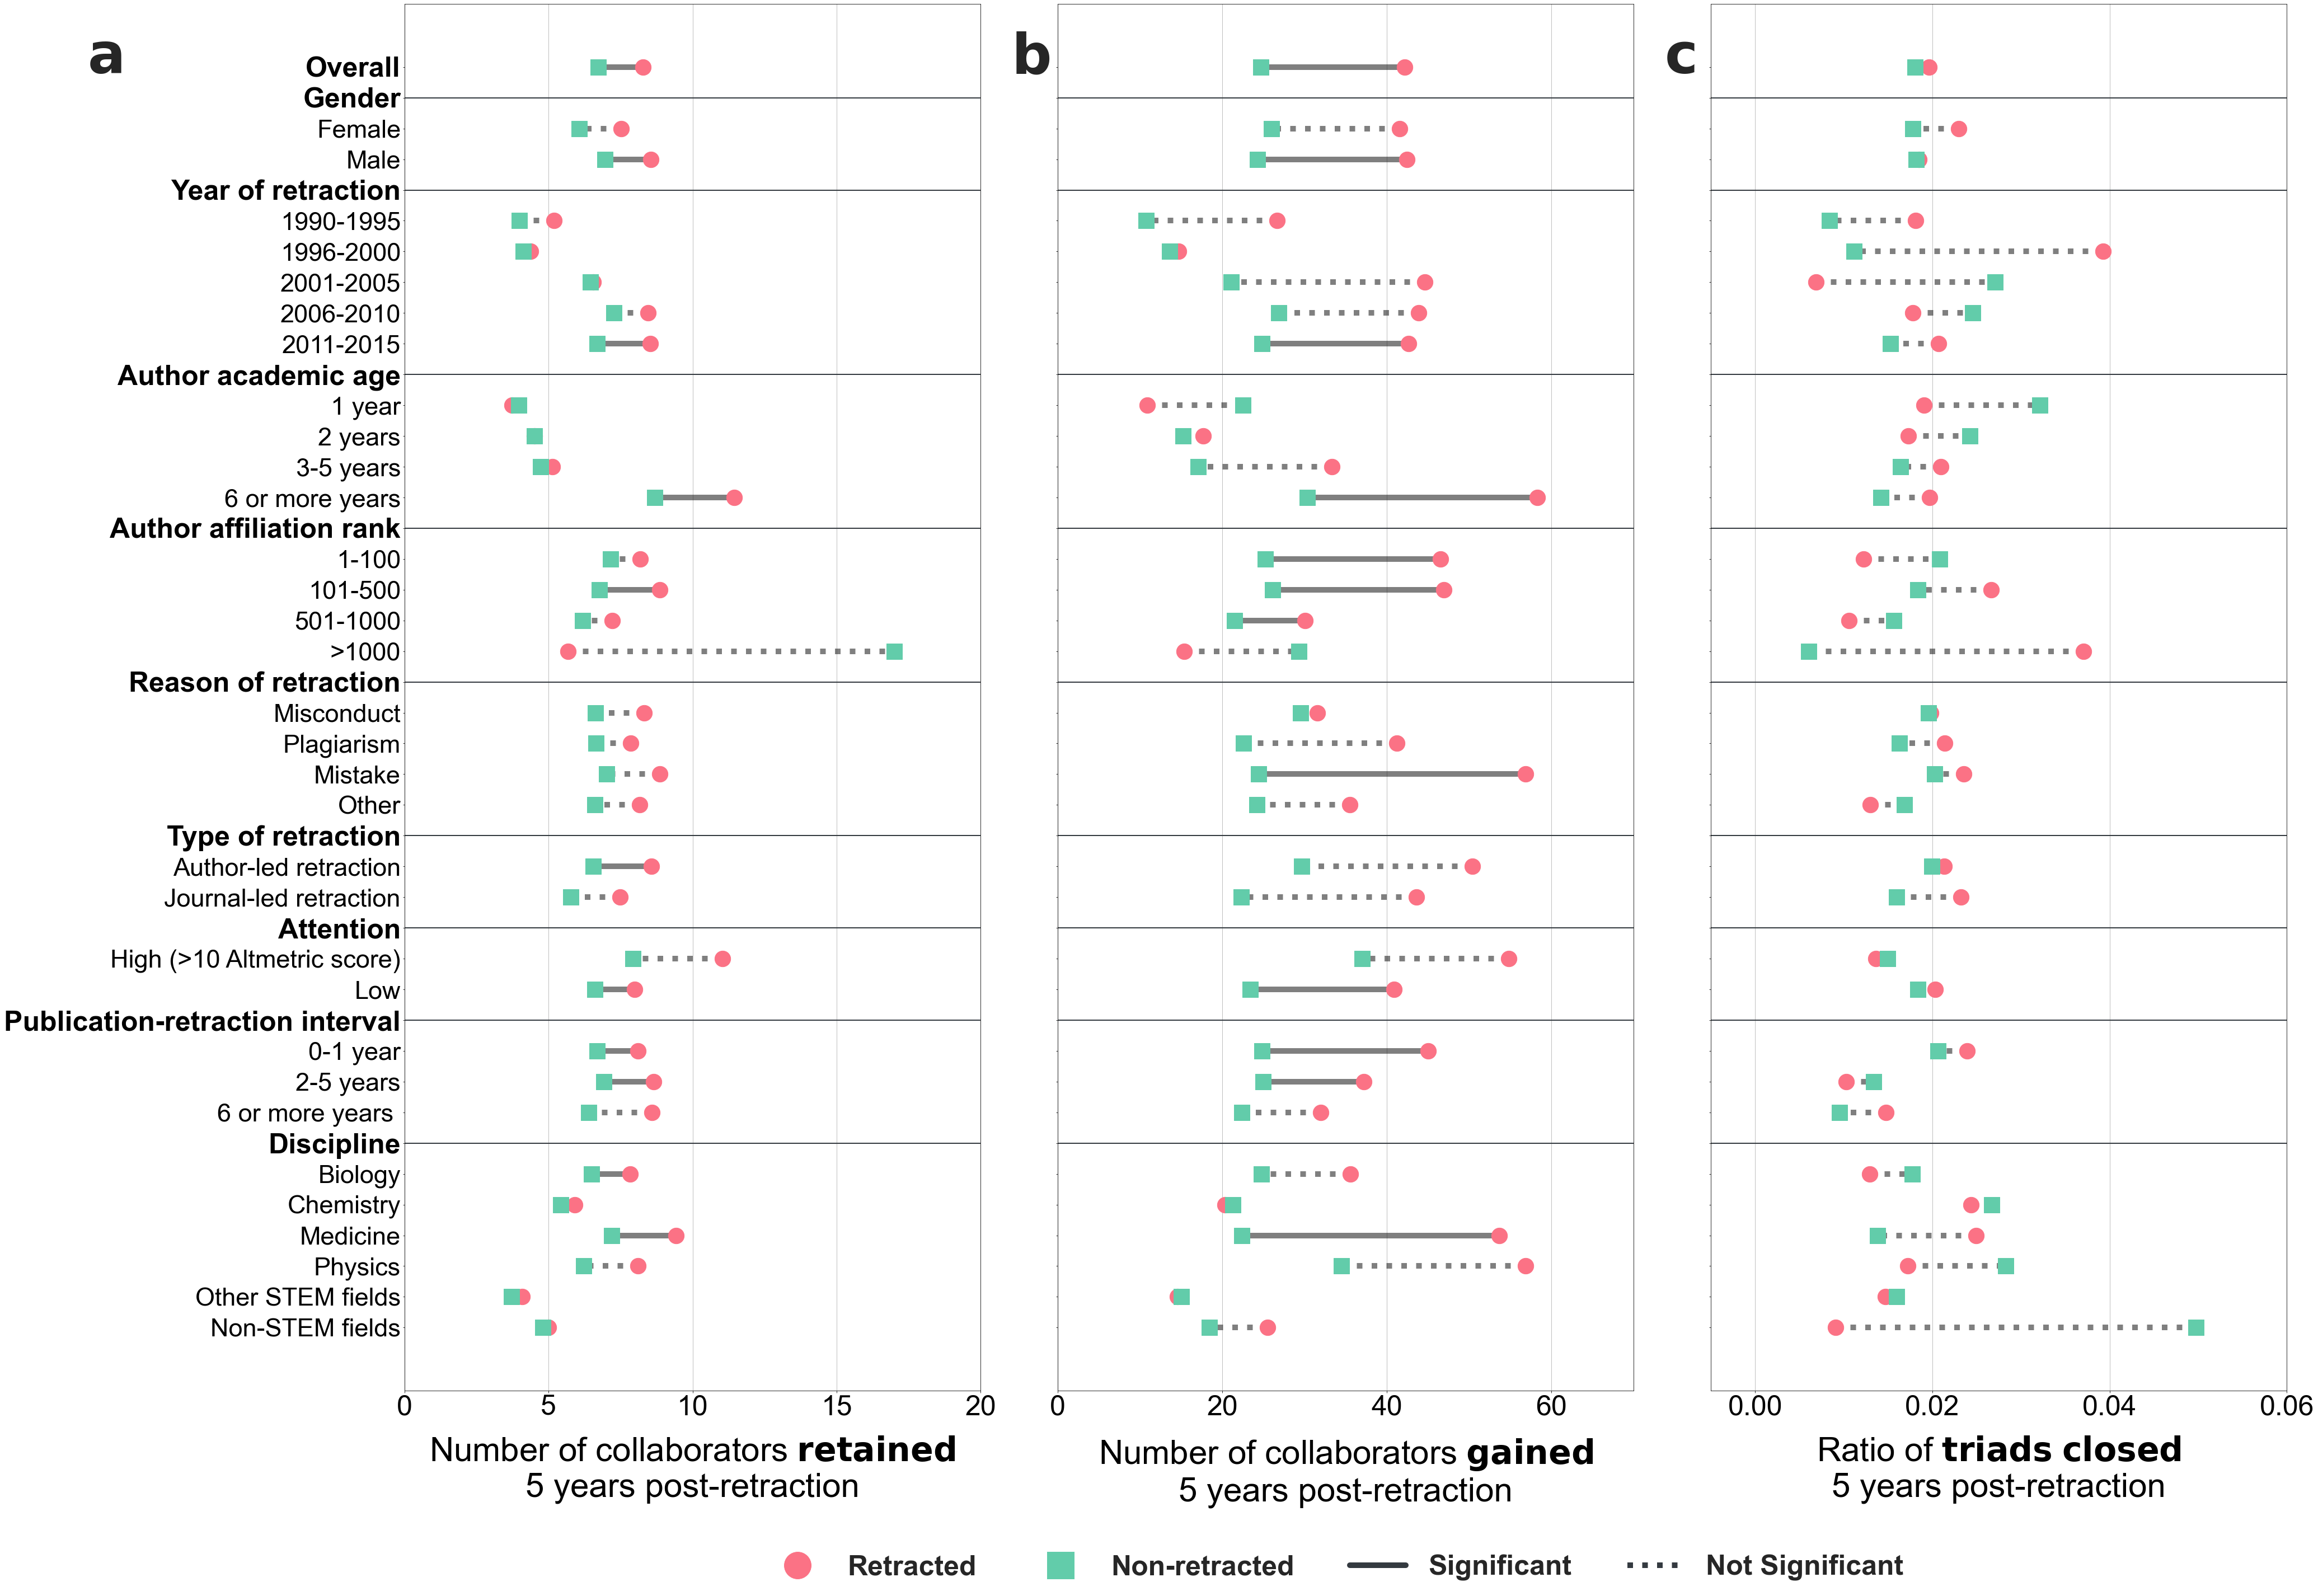

In [32]:
# Setting up the plot surface
fig = plt.figure(figsize=(60, 40))
gs = GridSpec(nrows=3, ncols=15)

number_of_strata = 10

def label_subplots(axi, labeli, xi=-0.1, yi=1.03):
    
    # Labeling the figure so that they can be referred in the paper
    axi.text(xi, yi, labeli, transform=axi.transAxes, fontfamily='DejaVu Sans',
      fontsize=100, fontweight='extra bold')

# Zeroeth axes for dot plot for retention for full matched sample
ax0 = fig.add_subplot(gs[:3, :5])

# First axes for dot plot for gain for full matched sample
ax1 = fig.add_subplot(gs[:3, 5:10], sharey = ax0)

# Second axes for dot plot for triadic closure
ax2 = fig.add_subplot(gs[:3, 10:], sharey = ax0)

# Defining colors for treatment and control
colorp = [['#fb7285','#62ccaa']] * number_of_strata


# Creating the first set of dumbell plots
create_shared_dumbbell_chart([df_retention_pre,df_gain_pre, df_triadsNC_pre], [ax0,ax1,ax2],
                             ['RetentionTreatment','GainTreatment','NCTreatment'], 
                             ['RetentionControl','GainControl', 'NCControl'],
                               colorp = colorp,
                                lst_figtype = ['','','triad_post_attrition'],
                                lst_xlim=[[0,20],[0,70],[-0.005,0.06]],
                                lst_xlabeltext=['Number of collaborators '+\
                                                 r'$\bf{retained}$'\
                                                '\n5 years post-retraction', 
                                                'Number of collaborators '+\
                                                 r'$\bf{gained}$'\
                                                '\n5 years post-retraction',
                                                'Ratio of '+\
                                                 r'$\bf{triads}$'+' '+r'$\bf{closed}$'\
                                                '\n5 years post-retraction',])

# Have to manually do this -- don't know why
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)


# Defining legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Retracted',
                      markerfacecolor='#fb7285', markersize=50),
              Line2D([0], [0], marker='s', color='w', label='Non-retracted',
                      markerfacecolor='#62ccaa', markersize=50),
                Line2D([0], [0], linestyle='solid', color='#343a40', 
                       label='Significant',lw=10),
                Line2D([0], [0], linestyle='dotted', color='#343a40', label='Not Significant',
                      lw=10)]

# Adding padding between figures
plt.tight_layout(pad=8)

# Annotating figures
label_subplots(ax0, "a", xi=-0.55, yi=0.95)
label_subplots(ax1, "b", xi=-0.08, yi=0.95)
label_subplots(ax2, "c", xi=-0.08, yi=0.95)

# Adding legend
plt.legend(handles=legend_elements, loc='upper center', ncol=4,
          prop={'size': 50}, bbox_to_anchor=(-0.65, -0.10), frameon=False)


plt.savefig(OUTDIR+'/matching_analysis_firstlastauthor_new.pdf',format='pdf', bbox_inches='tight')